(Intro_PyTensor)=

# What is PyTensor?
:::{post} August 16, 2025 
:tags: introduction, worked examples, tutorial
:category: beginner, explanation 
:author: Jesse Grabowski, Ricardo Vieira
:::

A library to define, manipulate, and compile computational graphs.


## Let's break it apart
A library to (1.) define, (2.) manipulate, and (3.) compile (0.) computational graphs.

## (0.) Computational graph

Any program implies a computational graph [citation needed]. In PyTensor we're mostly focusing on static, array-based (i.e, numpy) programs with some branching and looping primitives. PyTensor is hackable, and can be easily extended to represent arbitrary types and operations. That said, its usefulness quickly vanishes as you venture out of its area of focus.

Everyone here is likely familar with the idea of a computation graph, but let's look at a quick example anyway. Consider a program that computes $z = x + y$. Here we have:

- Two symbolic inputs, $x$ and $y$
- An operator, $+$, that takes several inputs and maps them to a single output
- A symbolic output, $z$

Visualized:

In [1]:
import graphviz as gr


def draw_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(
        graph_attr={"rankdir": graph_direction, "ratio": "0.3", 
                    'overlap':'vpsc',
                    'splines':'true',
                    'mode':'sgd',
                    'lheight':'4'},
        engine="dot",
    )

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g


While this DAG is boring and obvious, it highlights that there are two types of nodes:

- Variables
- Operations

We can also distinguish between "root variables", like $x$ and $y$, intermediate variables (we don't have any here :( ) and output variables ($z$). These differences will return in a few slides!

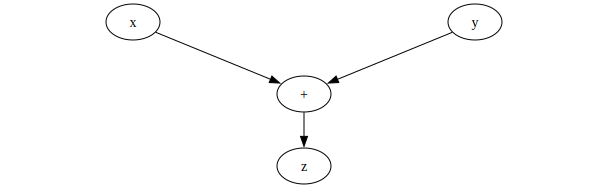

In [2]:
draw_graph([('x', '+'),
            ('y', '+'),
            ('+', 'z')])

## (1.) Definition 
In PyTensor, you define a computational graph explicitly, starting with _placeholder_ input variables. From these inputs you build more intermediate variables by applying operators (like $+$), which can then be treated either as outputs, or as intermediate variables for further computation.

To reduce the learning barrier, Pytensor was designed to look like numpy code. But be aware that it's not! Let' look at some differences.

In [3]:
import numpy as np

# Numpy
x = np.array([0, 1, np.e])  # Actual numbers
y = np.log(1 + x) # Actual computation
y # Actual result

array([0.        , 0.69314718, 1.31326169])

The most important thing to grok here is that `y` is not a number! It's a symbol. Specifically, it's the output of a `Log` operation, so we see the name `Log.0`. The type is a `TensorVariable`, which is a basic unit of symbolic computation.

Notice how Pytensor is straddling a line between a computer algebra system like sympy or maple, and a tensor library like numpy.

In [4]:
import pytensor
import pytensor.tensor as pt

# Pytensor
x = pt.tensor(shape=(3,), dtype="float64")  # Symbolic vector
y = pt.log(1 + x)  # Symbolic computation
y, type(y)

(Log.0, pytensor.tensor.variable.TensorVariable)

A key tool when working with Pytensor is `dprint`. It's short for "debug print", and it shows you a text representation of a graph. It's always a good idea to look at the graph pytensor is generating for your graph, because it shows you exactly what is going on. Admittedly, they take a bit of getting used to reading.

In [5]:
y.dprint()

Log [id A]
 └─ Add [id B]
    ├─ ExpandDims{axis=0} [id C]
    │  └─ 1 [id D]
    └─ <Vector(float64, shape=(3,))> [id E]


Pytensor can also generate visual representations of your graph. You will be forgiven if you think this is a much better way to view a graph. It's great, but doesn't scale well at all. For large graphs, the output is completely unreadable. If anyone is interested in developing tensorboard-like tools that will allow for interactive investigation of a graph, PRs are accepted!

That said, here's the visual representation of our graph. It's very similar to our $z = x + y$ graph, with a some extra computational accoutrement. 

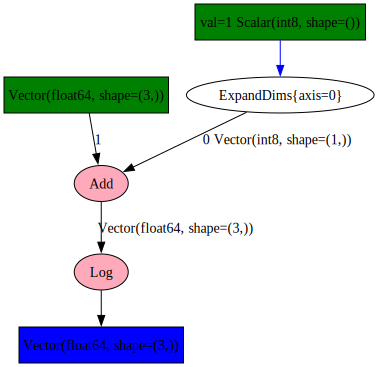

In [6]:
from pytensor.printing import pydotprint
from IPython.display import SVG

SVG(pydotprint(y, return_image=True, format="svg"))

For those curious: This kind of graph is a bi-partite, directed, acyclic graph composed of interconnected Variable -> Apply -> Variable nodes.

Apply nodes connect input variables to output variables, via a specific operator. Variables have a type and can have an owner (the Apply node that creates them) or not (if they are root placeholder variables).

Here is a schematic of the $z = x + y$ graph again, but this time with annotations that show how it is represented in Pytensor. I always felt it was upside-down; perhaps that feeling will help you to understand what you're looking at. Read it from top-to-bottom, but with the flow of computation running against the arrows:

![](https://pytensor.readthedocs.io/en/latest/_images/apply.png)

We can see these definitions in action by looking at properties of `y`. We've already seen that `type(y)` is a `TensorVariable`. With the exception of root variables, all `TensorVariables` have an `owner`, which is the `Apply` node that created it. 

In this case, the owner of `y` is `Log(Add.0)`. `Add.0` is the name of the output of an `Add` `Op`, so `y` is the result of a `Log` applied to an `Add`.

In [7]:
y.owner, type(y.owner)

(Log(Add.0), pytensor.graph.basic.Apply)

Looking at the schematic again, note that there is a conceptual difference between `Apply` (which is a big box that handles a bunch of stuff) and an `Op`, which is the actual type of computation being done. 

In this case, the specific Op is an `Elemwise`, which is a meta-Op that broadcasts a scalar computation (in this case `scalar_op = log`) across a tensor input. It makes it an elementwise operation... hence "Elemwise Op".

In [8]:
y.owner.op, type(y.owner.op)

(Elemwise(scalar_op=log,inplace_pattern=<frozendict {}>),
 pytensor.tensor.elemwise.Elemwise)

We can also check the outputs of the `Apply`. This is, of course, `y` itself!

In [9]:
y.owner.outputs, y.owner.outputs == [y]

([Log.0], True)

Finally, there's the inputs. This is `Add.0`, which represents `1 + x`

In [10]:
y.owner.inputs

[Add.0]

From here, the story begin again, and we can keep climbing up the graph until the root variable, `x`. I'll spare you, though

In [11]:
y.owner.inputs[0].dprint()  # And the story begins again

Add [id A]
 ├─ ExpandDims{axis=0} [id B]
 │  └─ 1 [id C]
 └─ <Vector(float64, shape=(3,))> [id D]


## (2) Manipulation

So far, nothing we've seen is special. Maybe it's a nice API for writing functions, but it's not at all clear why the program `y = pt.log(1 + x)` is better than the following Python program:

```py
def log1p(x):
    return np.log(1 + x)
    
y = log1p(x)
```

Actually, this is the exact API that JAX offers! Setting aside jax, we might even take this function and decorate it with `@numba.njit`, potentially getting big speedups. What does pytensor offer us?

The answer is that PyTensor is able to **manipulate** the computation graph. Furthermore, these manipulations are done within Python. JAX, for example, is able to trace the above function to construct a computational graph. But the graph representation is not front-and-center, and it's no obvious how to use it. In Pytensor, you are meant to be working direcly on graphs!

There are three important graph operations to consider:

1. Replacement
2. Rewriting
3. Transformation

We will look at each of these in turn.

### Graph Replacement

The simplest graph operation is a **replace**. We simply take one operation and swap it out for another. Consider the following graph:

In [12]:
a = pt.tensor('b', shape=(None, ))
b = 2 * pt.pi * a
c = pt.sin(b)
d = 1 + c
d.dprint()

Add [id A]
 ├─ ExpandDims{axis=0} [id B]
 │  └─ 1 [id C]
 └─ Sin [id D]
    └─ Mul [id E]
       ├─ ExpandDims{axis=0} [id F]
       │  └─ 6.283185307179586 [id G]
       └─ b [id H]


If, for some reason, we wanted to do replace `pt.sin(b)` with `pt.cos(b)`, we could do so with the `graph_replace` function. The subgraph we want to target is `c`, and the top-level output is `d`, so we do it as follows:

In [13]:
from pytensor.graph.replace import graph_replace
z2 = graph_replace(d, {c: pt.cos(b)})
z2.dprint()

Add [id A]
 ├─ ExpandDims{axis=0} [id B]
 │  └─ 1 [id C]
 └─ Cos [id D]
    └─ Mul [id E]
       ├─ ExpandDims{axis=0} [id F]
       │  └─ 6.283185307179586 [id G]
       └─ b [id H]


This might seem like a silly example, but one-to-one transformations are quite common! For example, suppose we had a graph with a random variable, and we wanted to replace the random variable with a root variable, transforming it into a function. We can do that with graph replace too:

In [14]:
x = pt.random.normal(loc=0, scale=1, size=(10,))
y = pt.exp(x)
y.dprint()

Exp [id A]
 └─ normal_rv{"(),()->()"}.1 [id B]
    ├─ RNG(<Generator(PCG64) at 0x1126B3AE0>) [id C]
    ├─ [10] [id D]
    ├─ ExpandDims{axis=0} [id E]
    │  └─ 0 [id F]
    └─ ExpandDims{axis=0} [id G]
       └─ 1 [id H]


In [15]:
x_input = pt.tensor('x_input', shape=(10, ))
y2 = graph_replace(y, {x: x_input})
y2.dprint()

Exp [id A]
 └─ x_input [id B]


#### Vectorization

A less trivial type of graph replacement is *vectorization*. This is also a one-to-one replacement, but this time things are somewhat more complicated, because it changes the meaning of the graph. Pytensor will automatically reason about the broadcasting operations that need to happen to accomplish the replacement.

This time, I make a graph where all the inputs are specifically declared to be scalars. Notice how this information flows down the graph: since `x` is scalar, and the `Op`s `log` and `add` are elemwise, the output `y` is also a scalar.

In [16]:
x = pt.dscalar('x')
y = pt.log(1 + x)
y.dprint(print_type=True)

Log [id A] <Scalar(float64, shape=())>
 └─ Add [id B] <Scalar(float64, shape=())>
    ├─ 1 [id C] <Scalar(int8, shape=())>
    └─ x [id D] <Scalar(float64, shape=())>


Suppose that instead of a scalar `x`, we want to use this function for a vector input. If we naively try to `graph_replace` here, we will get a shape error

In [17]:
x_vec = pt.tensor('x_vec', shape=(None,))
try:
    graph_replace(y, {x: x_vec})
except Exception as e:
    print(e)

Cannot convert Type Vector(float64, shape=(?,)) (of Variable x_vec) into Type Scalar(float64, shape=()). You can try to manually convert x_vec into a Scalar(float64, shape=()).


Instead, use `vectorize_graph`!

In [18]:
from pytensor.graph.replace import vectorize_graph
y_vec = vectorize_graph(y, {x:x_vec})
y_vec.dprint(print_type=True)

Log [id A] <Vector(float64, shape=(?,))>
 └─ Add [id B] <Vector(float64, shape=(?,))>
    ├─ ExpandDims{axis=0} [id C] <Vector(int8, shape=(1,))>
    │  └─ 1 [id D] <Scalar(int8, shape=())>
    └─ x_vec [id E] <Vector(float64, shape=(?,))>


### Rewrites

Rewrites are at the heart of pytensor's usefulness. Pytensor maintains large databases of useful graph transformations. These can be applied to acheive a number of goals.

#### Scalarization

We can even undo vectorization -- scalarization?

Here's the original graph:

In [19]:
y_vec[0].dprint()

Subtensor{i} [id A]
 ├─ Log [id B]
 │  └─ Add [id C]
 │     ├─ ExpandDims{axis=0} [id D]
 │     │  └─ 1 [id E]
 │     └─ x_vec [id F]
 └─ 0 [id G]


Notice how the indexing operation has been pushed down to the input!

In [20]:
from pytensor.graph import rewrite_graph

rewrite_graph(y_vec[0]).dprint()

Log [id A]
 └─ Add [id B]
    ├─ 1.0 [id C]
    └─ Subtensor{i} [id D]
       ├─ x_vec [id E]
       └─ 0 [id F]


#### Stabilization

Calling `rewrite_graph` without any arguments will trigger many rewrites to be applied. If you have a more specific objective, you can ask for specific types of rewrites. For example, the `stabilize` tag includes rewrites that can transform your graph into a form that is more numerically stable

In [21]:
x = pt.tensor('x', shape=(None, ))
y = pt.log(1 + x)
y.dprint(print_type=True)

Log [id A] <Vector(float64, shape=(?,))>
 └─ Add [id B] <Vector(float64, shape=(?,))>
    ├─ ExpandDims{axis=0} [id C] <Vector(int8, shape=(1,))>
    │  └─ 1 [id D] <Scalar(int8, shape=())>
    └─ x [id E] <Vector(float64, shape=(?,))>


In [22]:
stable_y = rewrite_graph(y, include=("stabilize",))
stable_y.dprint()

Log1p [id A]
 └─ x [id B]


There are many more types of rewrites, and we will see them shortly. But first we need to do a Quinten Tarintino and show things somewhat out of order. 

### Graph-to-graph transformations

The most powerful feature of pytensor is to take a graph and return another graph. 

We've already seen one example of this in `vectorization`. I included it above because it "looks like" `graph_replace`, in the sense that you target a single node for replacement. But as we saw, `vectorize_graph` returns an entirely new graph, with new shapes.

The canonical example of a graph-to-graph transformation is automatic differentiation. If we know the derivative of every `Op` in our graph, we work backwards and follow the chain rule to construct a gradient graph from the graph of a scalar loss function.

The cryptic Op called `Second` means: keep the second input after broadcasting the shape with the first.
It's the same as `np.broadcast_arrays(x, y)[1]`

In [23]:
from pytensor.gradient import grad
grad_y = grad(stable_y.sum(), wrt=x)
grad_y.dprint()

True_div [id A]
 ├─ Second [id B]
 │  ├─ Log1p [id C]
 │  │  └─ x [id D]
 │  └─ ExpandDims{axis=0} [id E]
 │     └─ Second [id F]
 │        ├─ Sum{axes=None} [id G]
 │        │  └─ Log1p [id C]
 │        │     └─ ···
 │        └─ 1.0 [id H]
 └─ Add [id I]
    ├─ ExpandDims{axis=0} [id J]
    │  └─ 1 [id K]
    └─ x [id D]


#### Quick digression: back to rewrites!

Gradient graphs tend to be complex, so it's nice to simplify them. 

One type of simplification is *canonicalization*. It converts a graph into a "standard" form. Other rewrites can expect and reason from this form. I think you'll agree this form is much nicer.

In [24]:
rewrite_graph(grad_y, include=("canonicalize",)).dprint()

True_div [id A]
 ├─ [1.] [id B]
 └─ Add [id C]
    ├─ [1.] [id B]
    └─ x [id D]


We can also compose rewrites! In this next example, we both canonicalize, then apply specializations to get computational speedups.

This also reveals the "final form" of the gradient: $\log(1 + x) = \frac{1}{1 + x}$

In [25]:
rewrite_graph(grad_y, include=("canonicalize", "specialize")).dprint()

Reciprocal [id A]
 └─ Add [id B]
    ├─ [1.] [id C]
    └─ x [id D]


#### Back to transformations -- logp inference

Another important graph-to-graph transformation is *automatic logp inference*. PyMC knows how to transform a generatve graph (forward draws) into a logp graph (backwards inference). 

You all know how PyMC works, so I'll spare you an example.

#### Integration

Okay, Pytensor can't do everything. But maybe you can extend it to! Integration would be another example of a graph-to-graph transformation :)

### Composability

It is important to note that all of these transformation operations are *composable*. We already saw an example of this when we applied graph rewrites to a gradient graph. We can also vectorize gradients, or take the gradient of a vectorize graph. Or we can replace subgraphs before or after applying rewrites. Because all of these operations take in a graph and return a graph, we're always able to chain together graph operations. 

Sometimes, you'll be surprised by what you end up with:

In [26]:
x = pt.tensor('x', shape=(3,))
y = pt.log(1 + x)
y.dprint()

Log [id A]
 └─ Add [id B]
    ├─ ExpandDims{axis=0} [id C]
    │  └─ 1 [id D]
    └─ x [id E]


The graph we've been working with is $y = \log(1 + x)$. Let's transform it to be $y = \log(1 + \exp(x))$, then rewrite the expression for stability.

First replace $x$ by $\exp(x)$:

In [27]:
new_y = graph_replace(y, replace={x: pt.exp(x)})
new_y.dprint()

Log [id A]
 └─ Add [id B]
    ├─ ExpandDims{axis=0} [id C]
    │  └─ 1 [id D]
    └─ Exp [id E]
       └─ x [id F]


Then optimize the graph for stability:

In [28]:
rewrite_graph(new_y, include=("stabilize",)).dprint()

Scalar_softplus [id A]
 └─ x [id B]


Did you guess the result would be just a single Op?

## (3) Compilation

All this is fun and dandy but only useful if we actually use it compute stuff! 

PyTensor provides a critical non-composable graph operation: `function`, which converts a pytensor graph into a callable python object that takes concrete inputs and returns concrete outputs. 

By default it runs an extensive database of rewrites to try and optimize the computational graph, and then compiles to C (technically a mix of C and Python if not all operations have a C implementation). See https://pytensor.readthedocs.io/en/latest/extending/pipeline.html for a bit more detail.

As with anything remotely useful in Python, when it comes to work you want to [STAY OUT OF PYTHON](https://www.youtube.com/watch?v=vVUnCXKuNOg) as much as possible.

In [29]:
x = pt.vector("x", shape=(None,))
z = pt.exp(pt.sin(x))
out = pt.cos((z[None, :] @ z[:, None]).squeeze())
out.dprint()

Cos [id A]
 └─ Squeeze{axes=[0, 1]} [id B]
    └─ Matmul [id C]
       ├─ ExpandDims{axis=0} [id D]
       │  └─ Exp [id E]
       │     └─ Sin [id F]
       │        └─ x [id G]
       └─ ExpandDims{axis=1} [id H]
          └─ Exp [id E]
             └─ ···


As noted, use `pytensor.function` to compile a graph into an executable program. You need to pass a **list** of inputs (even if it has no inputs, you still need an empty list!), and outputs (this *can* be a list, but isn't required to be.

In [30]:
y_fn = pytensor.function([x], out)

What we get back is a `Function` object. This is a wrapper around a call out to a compiled `C` program that now lives in some cache folder somewhere on your computer.

In [31]:
type(y_fn)

pytensor.compile.function.types.Function

And now we can use it like any other python function

In [32]:
y_fn(np.random.randn(3))

array(-0.1349928)

In [33]:
y_fn(np.random.randn(5))

array(-0.96096836)

We can also inspect it to see the final graph that was compiled, after applying rewrites. Notice that `dot` became `CGemv`, so we're using the correct BLAS routine for the inputs provided. It also did some *loop fusion* by compiling a composite inner graph. That is, if we give an array input, rather than looping over it once to compute `exp` of each element, then looping over it again to compute `sin` of each element, we instead loop only once, and compute $\exp \circ \sin$ of each element.

In [34]:
y_fn.dprint(print_destroy_map=True)  # Some memory aliasing optimizations

Cos [id A] d={0: [0]} 5
 └─ Squeeze{axis=0} [id B] 4
    └─ CGemv{inplace} [id C] d={0: [0]} 3
       ├─ AllocEmpty{dtype='float64'} [id D] 1
       │  └─ 1 [id E]
       ├─ 1.0 [id F]
       ├─ ExpandDims{axis=0} [id G] 2
       │  └─ Composite{exp(sin(i0))} [id H] 0
       │     └─ x [id I]
       ├─ Composite{exp(sin(i0))} [id H] 0
       │  └─ ···
       └─ 0.0 [id J]

Inner graphs:

Composite{exp(sin(i0))} [id H]
 ← exp [id K] 'o0'
    └─ sin [id L]
       └─ i0 [id M]


By passing `print_destroy_map=True` to `dprint`, we also get to see where memory buffers are being reused. This shows up in the graph with the line `d={x: [y]}`, where "x" is an output, and "y" is an input that will be re-used as a buffer. We can see this in two places:

- In the `CGemv` line, we have `d={0: [0]}`. This means that the first output is being allocated to the memory used for the first input. In this case, we save allocation of a length 1 array, which isn't so impressive.

- More interestingly, we see it at the top line, `Cos [id A] d = {0: [0]}`. This means that we are doing the `Cos` directly on the squeezed output of the CGemv operation! This is equivalent to `np.cos(x, out=x)`, which qucikly can become unreadble. 

PyTensor can also delegate compilation to other libraries in town, namely Numba, JAX, and PyTorch (latter still under active development). 

Notice that this is another kind of graph-to-"graph" transformation, that we can only do because we have access to the whole static computation. Every individual `Op` knows what it means to become a Numba program, so we can just walk across the graph and generate the appropriate code.

Sometimes, this means that certain rewrites aren't applied! In this case, Numba does it's own BLAS optimizations. So we don't rewrite `dot -> CGemv`, we just leave it as dot.

In [35]:
y_numba_fn = pytensor.function([x], out, mode="NUMBA")
y_numba_fn.dprint(print_destroy_map=True)

Cos [id A] d={0: [0]} 5
 └─ Squeeze{axes=[0, 1]} [id B] 4
    └─ Dot [id C] 3
       ├─ ExpandDims{axis=0} [id D] 2
       │  └─ Composite{exp(sin(i0))} [id E] 0
       │     └─ x [id F]
       └─ ExpandDims{axis=1} [id G] 1
          └─ Composite{exp(sin(i0))} [id E] 0
             └─ ···

Inner graphs:

Composite{exp(sin(i0))} [id E]
 ← exp [id H] 'o0'
    └─ sin [id I]
       └─ i0 [id J]


In [36]:
y_numba_fn(np.random.randn(3))  # first time takes long, jit compilation actually happening

array(-0.5555015)

In [37]:
y_numba_fn(np.random.randn(5))

array(-0.74921664)

## A Full Example: Logistic Regression with Gradient Descent

To show everything in action together, let's look at how we would write a binary classification model, how we can train it using gradient descent, and how we can use the final program we get back.

First, let's set up the symbolic inputs. These will be the input data $X$ and targets $y$, as well as the initial values for alpha and beta. Our model will be:

$$ p = \sigma^{-1}(\alpha + X \beta) $$

Where $\sigma$ is the logistic function.

And we'll choose parameters $\alpha$ and $\beta$ to minimize the binary cross entropy between $p$ and the target labels, which will just be:

$$\mathcal{L} = -\frac{1}{N} \sum_{i=0}^N y_i \log(p_i) + (1 - y_i) \log(1 - p_i)$$

If there are any Bayesians in the audience, you will also recognize this as the negative log-likelihood of a Bernoulli GLM

In [38]:
X_pt = pt.tensor('X', shape=(None, None))
y_pt = pt.tensor('y', shape=(None, ))
alpha_pt = pt.tensor('alpha', shape=())
beta_pt = pt.tensor('beta', shape=(None, ))

p = pt.sigmoid(alpha_pt + X_pt @ beta_pt)
p.name = 'p_class_0'

loss = -(y_pt * pt.log(p) + (1 - y_pt) * pt.log(1 - p)).mean()
loss.name = 'cross_entropy'

To convince you that the text version of dprint is nicer, here's the big graphic plot for our loss function:

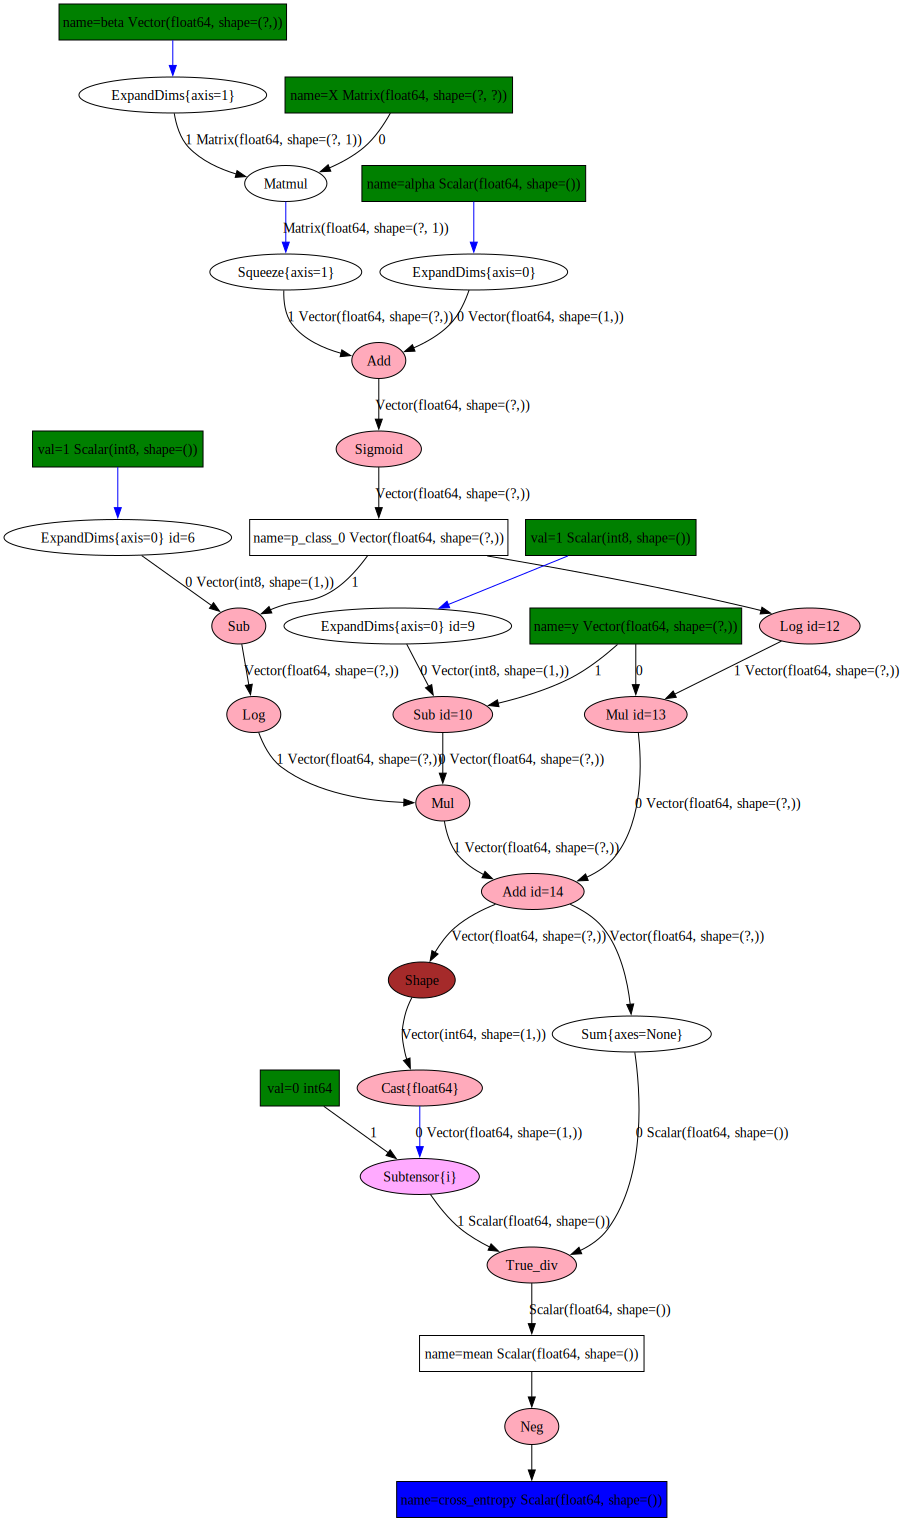

In [39]:
from pytensor.printing import pydotprint
from IPython.display import SVG

SVG(pydotprint(loss, return_image=True, format="svg"))

Comparsed to the text verison. It pays dividends to get used to reading these things!

In [40]:
loss.dprint()

Neg [id A] 'cross_entropy'
 └─ True_div [id B] 'mean'
    ├─ Sum{axes=None} [id C]
    │  └─ Add [id D]
    │     ├─ Mul [id E]
    │     │  ├─ y [id F]
    │     │  └─ Log [id G]
    │     │     └─ Sigmoid [id H] 'p_class_0'
    │     │        └─ Add [id I]
    │     │           ├─ ExpandDims{axis=0} [id J]
    │     │           │  └─ alpha [id K]
    │     │           └─ Squeeze{axis=1} [id L]
    │     │              └─ Matmul [id M]
    │     │                 ├─ X [id N]
    │     │                 └─ ExpandDims{axis=1} [id O]
    │     │                    └─ beta [id P]
    │     └─ Mul [id Q]
    │        ├─ Sub [id R]
    │        │  ├─ ExpandDims{axis=0} [id S]
    │        │  │  └─ 1 [id T]
    │        │  └─ y [id F]
    │        └─ Log [id U]
    │           └─ Sub [id V]
    │              ├─ ExpandDims{axis=0} [id W]
    │              │  └─ 1 [id X]
    │              └─ Sigmoid [id H] 'p_class_0'
    │                 └─ ···
    └─ Subtensor{i} [id Y]
       ├─ Cast{fl

To compute an update step, we will use a simple gradient descent algorithm, defined as:

$$\theta^\prime = \theta - \eta \nabla \mathcal{L}(\theta)$$

In [41]:
# The learning rate is another root variable we need to provide
eta_pt = pt.tensor('learning_rate', shape=())


# We can compute gradients for a list of varibales too! 
# It's also good to apply some graph simplification before taking gradients. PyMC does this
# by default, for example.
d_alpha, d_beta = grad(rewrite_graph(loss, include=('canonicalize', 'stabilize')),
                       wrt=[alpha_pt, beta_pt])

# Apply gradient updates
alpha_prime = alpha_pt - eta_pt * d_alpha
beta_prime = beta_pt - eta_pt * d_beta

Compile our functions. We can make one for training, and one for prediction. Here we see another example of a pytensor superpower: we don't have to know ahead of time how we want to use different outputs. We do all the steps of computation symbolically, then only at the end decide what will be used where. This type of thinking ahead is especially important when you're writing programs in numba. You will need to think about what units of computation can be decomposed and jitted, for reuse in later jitted functions. We see that pytensor does this reasoning for us.


Getting to this point, I realized that we can output class probabilities, but not class labels. It's easy to make one more root variable for the prediction function, representing a prediction threshold for membership in class 1. Then we can make a `y_hat` variable and return it.

In [42]:
training_fn = pytensor.function([X_pt, y_pt, eta_pt, alpha_pt, beta_pt], [loss, alpha_prime, beta_prime])

threshold = pt.tensor('threshold', shape=())
y_hat = (p > threshold).astype(int)
predict_fn = pytensor.function([X_pt, alpha_pt, beta_pt, threshold], [p, y_hat])

It's worth having a look at the dprint of `training_fn` to see a couple features of pytensor we haven't run into yet.

1. Sub-computations are automatically re-used! The first output, `Composite{...}.1 [id A] <Scalar(float64, shape=())> 9` is the cross entropy. It gets computed once (it's the first return, after all), but then it is also used in the 2nd return, to compute `alpha_prime`.
2. `Composite{...}.0 [id I] <Vector(float64, shape=(?,))> 4` is the probability of class 0. That also gets computed once and re-used several times.
3. Unused computations get truncated! Notice that `p_class_0` never appears as such. Instead, we got a composite sub-graph that compute that quantity given inputs. The thing itself was never requested, and is thus never used.

In [43]:
training_fn.dprint(print_type=True, print_destroy_map=True)

Composite{...}.1 [id A] <Scalar(float64, shape=())> 'cross_entropy' d={0: [1]} 10
 ├─ Assert{msg='Could not broadcast dimensi...'} [id B] <Scalar(int64, shape=())> 9
 │  ├─ Shape_i{0} [id C] <Scalar(int64, shape=())> 0
 │  │  └─ X [id D] <Matrix(float64, shape=(?, ?))>
 │  └─ ScalarFromTensor [id E] <bool> 8
 │     └─ Eq [id F] <Scalar(bool, shape=())> 7
 │        ├─ Shape_i{0} [id C] <Scalar(int64, shape=())> 0
 │        │  └─ ···
 │        └─ Shape_i{0} [id G] <Scalar(int64, shape=())> 6
 │           └─ y [id H] <Vector(float64, shape=(?,))>
 └─ Sum{axes=None} [id I] <Scalar(float64, shape=())> 5
    └─ Composite{...}.0 [id J] <Vector(float64, shape=(?,))> d={0: [1]} 4
       ├─ ExpandDims{axis=0} [id K] <Vector(float64, shape=(1,))> 3
       │  └─ alpha [id L] <Scalar(float64, shape=())>
       ├─ CGemv{inplace} [id M] <Vector(float64, shape=(?,))> d={0: [0]} 2
       │  ├─ AllocEmpty{dtype='float64'} [id N] <Vector(float64, shape=(?,))> 1
       │  │  └─ Shape_i{0} [id C] <Scalar(i

The last point about truncation is even more clear when we look at the graph for `predict_fn`. Now the loss is nowhere to be seen! We just compute exactly what was requested.

Note that we also have a nice example of re-using computation. We compute `p_class_0` exactly once, then re-use it in the 2nd output.

In [44]:
predict_fn.dprint(print_type=True)

Composite{...}.0 [id A] <Vector(float64, shape=(?,))> 'p_class_0' 5
 ├─ ExpandDims{axis=0} [id B] <Vector(float64, shape=(1,))> 4
 │  └─ alpha [id C] <Scalar(float64, shape=())>
 ├─ CGemv{inplace} [id D] <Vector(float64, shape=(?,))> 3
 │  ├─ AllocEmpty{dtype='float64'} [id E] <Vector(float64, shape=(?,))> 2
 │  │  └─ Shape_i{0} [id F] <Scalar(int64, shape=())> 1
 │  │     └─ X [id G] <Matrix(float64, shape=(?, ?))>
 │  ├─ 1.0 [id H] <Scalar(float64, shape=())>
 │  ├─ X [id G] <Matrix(float64, shape=(?, ?))>
 │  ├─ beta [id I] <Vector(float64, shape=(?,))>
 │  └─ 0.0 [id J] <Scalar(float64, shape=())>
 └─ ExpandDims{axis=0} [id K] <Vector(float64, shape=(1,))> 0
    └─ threshold [id L] <Scalar(float64, shape=())>
Composite{...}.1 [id A] <Vector(int64, shape=(?,))> 5
 └─ ···

Inner graphs:

Composite{...} [id A]
 ← sigmoid [id M] <float64> 'o0'
    └─ add [id N] <float64>
       ├─ i0 [id O] <float64>
       └─ i1 [id P] <float64>
 ← Cast{int64} [id Q] <int64> 'o1'
    └─ GT [id R] <boo

## Training

In [45]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt

seed = sum(map(ord, 'I <3 Pytensor'))
rng = np.random.default_rng(seed)

X, y = make_classification(n_samples=100, n_features=5, n_redundant=0, n_informative=5, n_classes=2, random_state=seed)

# Initial values for parameteres
beta = rng.normal(0, 1, size=(5,))
alpha = rng.normal(0, 1)

learning_rate = 1e-1

In [46]:
n_steps = 1000
histories = [np.empty(n_steps), np.empty(n_steps), np.empty((n_steps, 5))]
for t in range(n_steps):
    loss_val, alpha, beta = training_fn(X, y, learning_rate, alpha, beta)
    histories[0][t] = loss_val
    histories[1][t] = alpha
    histories[2][t] = beta

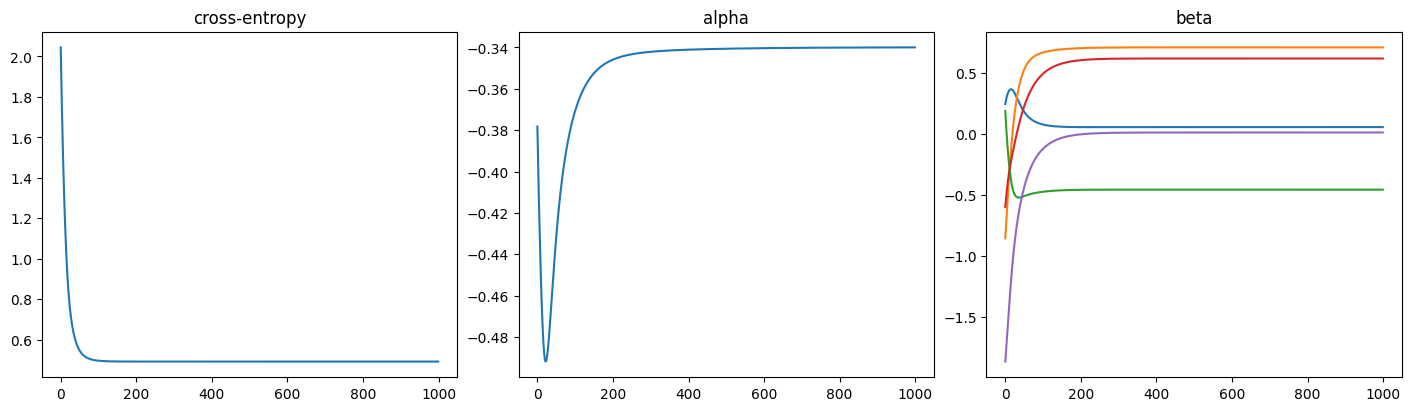

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4), layout='constrained')
for axis, data, name in zip(fig.axes, histories, ['cross-entropy', 'alpha', 'beta']):
    axis.plot(data)
    axis.set(title=name)
plt.show()

`make_classification` doesn't return true parameters to check against, so we'll just look at the confusion matrix. Seems like we learned something. It's a toy problem anyway!

In [48]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y, predict_fn(X, alpha, beta, 0.5)[1])

array([[36, 14],
       [11, 39]])

## Taking a step back



### How does it compare with alternative frameworks

* Graph is built explicitly with placeholder inputs (common source of confusion for users)
* It is focused on array (tensor) operations (dense and sparse). Tries to look almost like numpy / scipy, (until the abstraction breaks).
  * There is narrow / hidden support for other types like scalars, lists, slices, random Generators, strings, None (although easy to extend)
* Functional design (there is no variable mutation when defining graphs)
* Strong focus on hackability / graph manipulation
* It's completely ours! (And nobody else uses it)
* Evolved from:
  1. Theano which strongly inspired Tensorflow 1.x and JAX. Many concepts stood the test of time. Others have aged and provide some drag.
  2. Aesara, which cleaned up the codebase, added alternative backends (Numba and JAX) and proved there's some interest out there in a library like this.

### Why are we using it?

A mix of inertia/technical debt and Stockholm syndrome of course. 

More seriously, Theano strongly influenced the design (and unique strengths) of PyMC. The graph based approach turned out to be perfect for the Bayesian workflow where you can reuse the same program specification for very distinct goals: 

1. ancestral random sampling (prior predictive);
2. tuncated ancestral random sampling (posterior predictive);
3. probability transformation and differentiation (inference and optimization);
4. explicit graph manipulation (causal inference)

And so on. It's also nice that we can be opinionate about which of these is "best" for users to reason in (we chose 1), then define maps from the space of intuitive model definitions to whatever other space is best suited for a particular task. 

Many of the stabilization optimizations that PyTensor can do are very relevant for Bayesian inference, and it's great that users don't have to worry (as much) about it. For instance passing `logit_p=logits` or `p=pm.math.invlogit(logits)` yields exactly the same graph (and stabilization)! You may have known about log1p, but did you know about log1pexp (softplus above) and log1mexp?

On the other hand the laziness / abstraction level makes it easier to interoperate with other popular python libraries, like numpyro / blackjax (and more generally the  JAX ecosystem), NUMBA, and even libraries in different languages, luke nutpie and BART in RUST. All this would have been more limited or impossible if PyMC were to be built on a more eager/specialized computational framework.

In [49]:
%load_ext watermark
%watermark -n -u -v -iv -w -p numba,scikit-learn

Last updated: Sat Aug 16 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

numba       : 0.61.2
scikit-learn: 1.7.1

numpy     : 2.2.6
graphviz  : 0.21
matplotlib: 3.10.5
sklearn   : 1.7.1
pytensor  : 0+untagged.31285.g79444a3
IPython   : 9.4.0

Watermark: 2.5.0

